### Machine Learning - AdaBoost Binary  Classifier Example¶
### Kevin Jaggs July 2021

### Objective:
Train an ADABoost (ABC) algorithm to an input training database. Starting with a default parameter ABC model, the aim is to tune hyperparameters using GridsearchCV and improve initial classifier performance.

Outcomes at each stage will be scored using conventional binary classification scoring metrics.

### Dataset
A synthetic dataset with a binary outcome [0,1] in the last position. Most columns are discrete values [0,1,2,3,4,5] but some are continuous floats. Note: the supplied input file is a conditioned, synthetic binary classification dataset i.e binary outcome of 0 or 1. You can simply add in a user selected database with the following preconditions: 1) Nan or empty cell values will be replaced with zero, 2) binary outcome only, 3) the results column is the last one [-1].

### Programming
This evaluation is performed using Python code and SKlearn provides all the classifier modules.

At the time of script creation the following verions were used. Python: 3.7.3 Numpy: 1.18.1 Pandas: 1.0.0 SKlearn: 0.22.1

### Outputs
Confusion matrices for each model fit stage plus comparison AUC & Precision Recall plots. 

 ### Import required Python Modules
 

In [55]:
#print(__doc__)

#pandas dataframe - similar to a python version of excel. Most efficient way to perform data operations
import pandas as pd

#numpy for most mathematical operations
import numpy as np

#matplotlib for plotting functions
#import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#seaborn for plotting heatmap
#import seaborn as sns

#sklearn for machine learning modules and scoring algorithms
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

#SKlearn classifier and hyperparameter search modules
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, plot_confusion_matrix,classification_report
from sklearn.metrics import roc_curve,roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix,classification_report

#chi2 calculation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import scipy

#feature selection
from sklearn.feature_selection import SelectFromModel

#plotting
import matplotlib.pyplot as plt


import sys
import sklearn
print("Python version: ", sys.version_info[0],".",sys.version_info[1],".",sys.version_info[2])
print("Numpy Version: " ,np.__version__)
print("Pandas Version: " ,pd.__version__)
print("Scikitlearn Version: " ,sklearn.__version__)

Python version:  3 . 7 . 3
Numpy Version:  1.18.1
Pandas Version:  1.0.0
Scikitlearn Version:  0.22.1


### User selected parameters
Select scoring method, options of 'accuracy', 'precision', 'f1', 'roc_auc' Crossvalidation fold i.e how many subsets the training data is split into for cross validation purposes, recommend value above 3 as this below this point overfits the data and will create a prediction error in the final assessment.

In [56]:

#Accuracy - ratio of correctly predicted observation to the total observations. 
#Accuracy works best if false positives and false negatives have similar cost. 
#Accuracy = TP+TN/TP+FP+FN+TN

#Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
#High precision relates to the low false positive rate.
#Precision = TP/TP+FP

#Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class
#Recall = TP/TP+FN

#F1 score - F1 Score is the weighted average of Precision and Recall. Takes both false pos and false neg into account. 
#Use F1 if you have an uneven class distribution. 
#If the cost of false positives and false negatives are very different - look at both Precision and Recall.
#F1 Score = 2*(Recall * Precision) / (Recall + Precision)

#roc_auc - the area under the receiver operating characteristic, plots the False Positive rate vs True Positive Rate for different thrshold cut offs.
#The best models should plot towards the upper left quadrant of the plot, therefore calculating the area under the curve is a good measure of model performance.


#score_cat = 'roc_auc'
score_cat = 'accuracy'
#score_cat = 'precision'
#score_cat = 'f1_score'

#plot labels are updated based upon 
if score_cat == 'roc_auc':
    plot_label = 'AUC'
if score_cat == 'accuracy':
    plot_label = 'Accuracy'
if score_cat == 'precision':
    plot_label = 'Precision' 
if score_cat == 'recall':
    plot_label = 'Recall'    
if score_cat == 'f1_score':
    plot_label = 'f1 score'  
    
#number of folds (equal data subsets) employed in cross validation - recommended to use above 4 for this dataset    
cross_validation_fold = 5    

#confidnce interval for chi2 calculation
conf_int = 0.95

#see random number generators - for repeatability
random_seed = 57

### Import database csv file to pandas
The csv file is imported into a pandas dataframe, allowing ease of computation in later modules. All columns are considered numeric. The column header is the data category and the index is the row ID. There should be no Nan or empty cell values amd the output column is assumed to be in last column position.

In [57]:
def readcsvfile():
    '''
    (csv)->(pandas dataframe)
    routine to read import csv file to pandas
    comma separation, column headers = first row of text
    All column data is considered numeric
    Index = row 
    -999.25 values are converted to numpy NaN
    PRECONDITION: Import csv file is the correct format. All lines without a 1/0 output removed.
    KJAGGS June 2020
    '''
    
    #read csv file to pandas dataframe
    df = pd.read_csv('classification_dataset.csv', encoding = 'utf-8',header=0,sep=',', index_col=0)
    #df = df.set_index('Row ID')
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.replace(-999.25,np.NaN)
    df = df.replace(np.NaN,0)
    #print(df.isnull().any())
    return df

df = readcsvfile()

###optional qc features - remove hash/# to view 
#print(df.head)
#print(df.columns.tolist)


print("Dataframe size on import")
print("Number of prospects :", df.shape[0])
print("Number of data categories :", df.shape[1])

Dataframe size on import
Number of prospects : 352
Number of data categories : 43


### Split into test and train datasets
Data is divided into test and training sub-volumes for the purpose of fitting models and preventing over-fitting/bias issues. The current defaults in the module below are to split 80:20 train:test. No random number seeding, no shuffling of input data and no stratifying (equal proportions of success/fail outcomes in each sub-volume). These features are adjusted at the bottom of the next cell as the input to function; user can change accordingly.

In [58]:
def training_split(Xdata, Ydata, test_size=0.2,stratify=None,random_state=None,shuffle=False):
    '''
    (DataframeXColumns)(DataframeYColumn)=>(array)(array)(array)(array)
    For the purposes of splitting x and y data into test and training sets
    train_test_split is currently set to default settings
    PRECONDITION: Input datasets are formatted correctly
    KJAGGS June2020
    '''

    #split the data - default settings for now
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=test_size,stratify=stratify, random_state = random_state, shuffle = shuffle)

    #resize the output data sets if a 1 column vector, now compatible  with regression modules
    if len(X_train.shape) <2:  
       X_train = X_train.ravel()
    if len(y_train.shape) <2:  
       y_train = y_train.ravel()
    if len(X_test.shape) <2:  
       X_test = X_test.ravel()
    if len(y_train.shape) <2:  
       y_test = y_test.ravel()
    
    return X_train, X_test, y_train, y_test

#print(df.columns.tolist())
#output dataset is success/fail only
print(df.shape)

#remove result column from input dataset
y = df[df.columns[-1]]

#X = df.drop(df.columns[[-1]], axis=1)
#X = df.drop(df.columns[[1,-1]], axis=1)
X = df.drop(df.columns[[0,1,-1]], axis=1)



#split the datasets
#Shuffle = randomly shuffle the data before, If shuffle=False then stratify must be None.
#random state = seeding of random numbers for reproducibility across various modules
#stratify = ensure proportion of outcomes are the same across both datasets i.e % of successes in train = % of successes in test
X_train, X_test, y_train, y_test = training_split(X,y,shuffle=True,random_state=random_seed,stratify=y,test_size=0.25)

print("Train and test dataset sizes")
print("Training dataset size :", X_train.shape)
print("Test dataset size :", X_test.shape)
(352, 43)


(352, 43)
Train and test dataset sizes
Training dataset size : (264, 40)
Test dataset size : (88, 40)


(352, 43)

### Train default parameter Random Forest Classifer
Using only the default parameters an SKlearn ABC is fitted to the input training dataset and performance is reviewed using a classification report and confusion matrix. Model outputs are saved for further comparison later.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

              precision    recall  f1-score   support

         0.0       0.62      0.68      0.65        41
         1.0       0.70      0.64      0.67        47

    accuracy                           0.66        88
   macro avg       0.66      0.66      0.66        88
weighted avg       0.66      0.66      0.66        88

Default model  AUC score:  0.7026466009340945


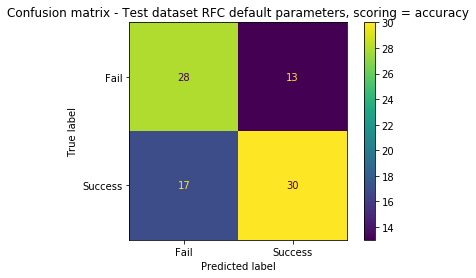

In [59]:
clf_raw = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=1000,random_state=random_seed)

clf_raw.fit(X_train, y_train)

#Predict the response for test dataset
#_raw suffix is used to identify this model in the final model reviews
y_pred_raw = clf_raw.predict(X_test)

#y_score_raw = clf_raw.predict_proba(X_test_scaled)
#retains positive values only
y_score_raw = clf_raw.predict_proba(X_test)[:,1]

# print classification report 
print(classification_report(y_test, y_pred_raw)) 

#confusion matrix plot
disp = plot_confusion_matrix(clf_raw,X_test,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - Test dataset RFC default parameters, scoring = ' + score_cat)

#print(title)
#print(disp.confusion_matrix)

print("Default model  AUC score: ", roc_auc_score( y_test, y_score_raw))

### Perform GridsearchCV to fine tune hyperparameters.
Using GridSearchCV output as a guide, identify the hyperparameter values to optimise model performance.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=random_seed))

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10,15,20],
              'n_estimators':[10,50,250,500],
              'learning_rate':[0.001, 0.01,0.1]}

clf_cv = GridSearchCV(abc, parameters,verbose=3,scoring='accuracy',n_jobs=-1)
clf_cv.fit(X_train,y_train)

### GridsearchCV model evaluation.

Evaluate the final GridsearchCV hyperparameter selection model using a classification report and confusion matrix.

Gridsearchcv best parameters:
{'base_estimator__max_depth': 2, 'base_estimator__min_samples_leaf': 15, 'learning_rate': 0.1, 'n_estimators': 50}
              precision    recall  f1-score   support

         0.0       0.65      0.59      0.62        41
         1.0       0.67      0.72      0.69        47

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88

GridsearchCV  AUC score:  0.7008303061754022


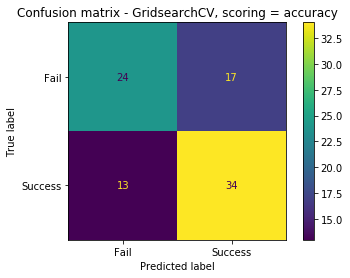

In [60]:
print("Gridsearchcv best parameters:")
print(clf_cv.best_params_)

#Predict the response for test dataset
#_rs suffix is used to identify this model as rondomised search
y_pred_cv = clf_cv.predict(X_test)

#retains positive values only
y_score_cv = clf_cv.predict_proba(X_test)[:,1]

# print classification report 
print(classification_report(y_test, y_pred_cv)) 

#confusion matrix plot
disp = plot_confusion_matrix(clf_cv,X_test,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - GridsearchCV, scoring = ' + score_cat)

print("GridsearchCV  AUC score: ", roc_auc_score( y_test, y_score_cv))

### ROC Plot
Comparison of the ROC curves for raw and GridsearchCV models. Labels show the AUC score.

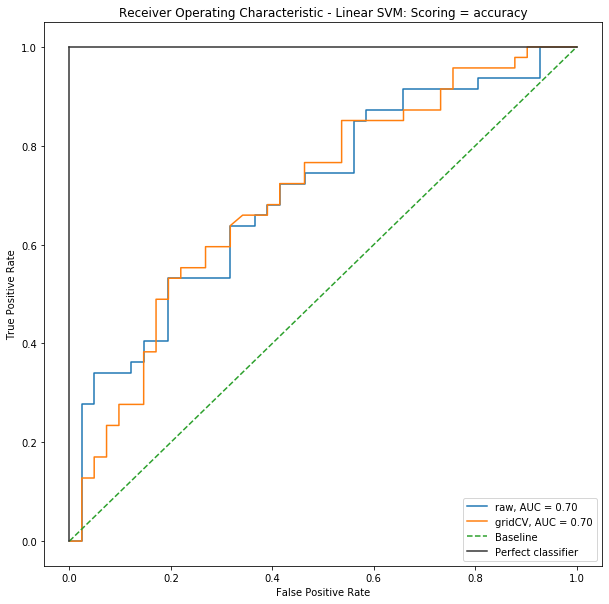

In [61]:
#ROC AUC Curve Generation for default model
false_positive_raw, true_positive_raw, threshold_raw = roc_curve(y_test, y_score_raw)

#ROC AUC Curve Generation for gridsearch CV model
false_positive_gridcv, true_positive_gridcv, threshold_tuned_feature = roc_curve(y_test, y_score_cv)


raw_auc_label = "raw, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_raw))
gridcv_auc_label = "gridCV, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_cv))


#Plot ROC Curve
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Linear SVM: Scoring = ' + score_cat)
plt.plot(false_positive_raw, true_positive_raw, label=raw_auc_label)
plt.plot(false_positive_gridcv, true_positive_gridcv, label=gridcv_auc_label)
plt.plot([0, 1], ls="--", label='Baseline')
plt.plot([0, 0], [1, 0] , c=".2"), plt.plot([1, 1] , c=".2",label="Perfect classifier")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()


### Precision vs Recall Plot
Comparison of the PR curves for raw and GridsearchCV models. Labels show the AUPR score.

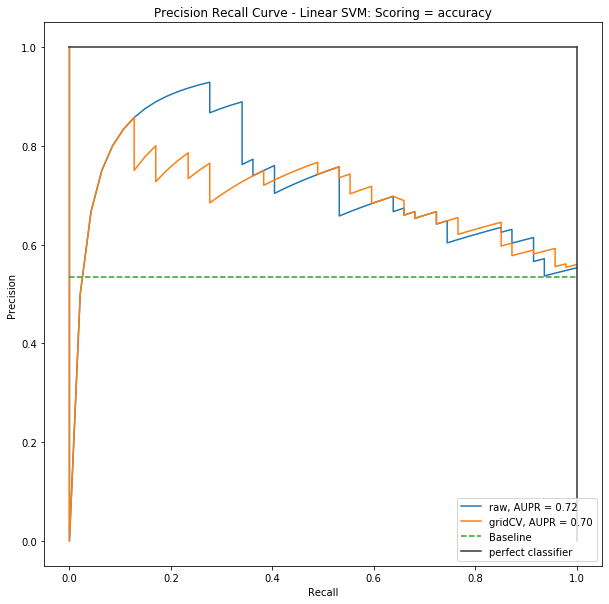

In [62]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


#AUPR Curve Generation for raw model
prec_raw, recall_raw, threshold_pr_raw = precision_recall_curve(y_test, y_score_raw)

#AUPR Curve Generation for gridsearch cv model
prec_gridcv, recall_gridcv, threshold_pr_tuned_feature = precision_recall_curve(y_test, y_score_cv)


raw_pr_label = "raw, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_raw))
gridcv_pr_label = "gridCV, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_cv))

baseline = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve


#Plot Precision Recall Curve
plt.subplots(1, figsize=(10,10))
plt.title('Precision Recall Curve - Linear SVM: Scoring = ' + score_cat)
plt.plot( recall_raw,prec_raw, label=raw_pr_label)
plt.plot( recall_gridcv,prec_gridcv, label=gridcv_pr_label)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.plot([0, 1], [1, 1] , c=".2"), plt.plot([1, 1] , [1, 0], c=".2",label="perfect classifier")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc="lower right")
plt.show()